# **Generating handwritten MNIST digits using GAN**

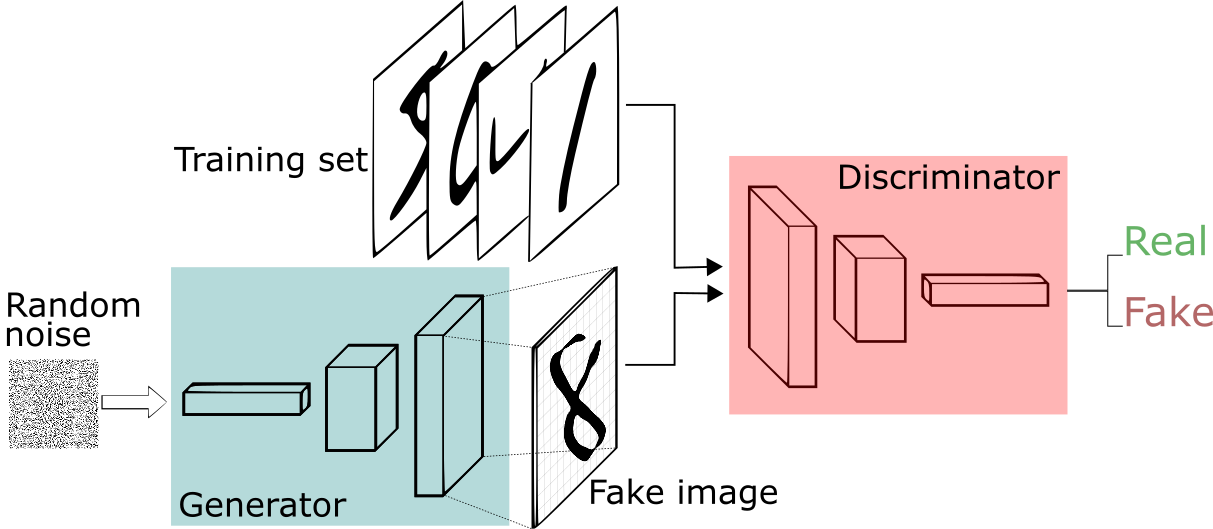

### Github link : https://github.com/amanchadha/coursera-gan-specialization/blob/main/C1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%201/C1W1_Your_First_GAN.ipynb

### **OBJECTIVES**

#### - Building Generator and Disscriminator network
#### - Generator and Discriminator loss functions.
#### - Training GAN and visualising the generated images

In [1]:
# importing required packages

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## Generator
#### Creating a single block for the generator's neural network.
#### Each block consists of follwing layers: 
#### - Linear layer
#### - Batch Normalization layer(for stabilization)
#### - ReLU activation layer

In [2]:
# Generator (for generating fake images)

class Generator(nn.Module):
  
    # z_dim : noise vector dimension
    # image_dimension : he dimension of the images, fitted for the dataset used, a scalar(MNIST images are 28 x 28 = 784)
    # hidden_dimension : inner dimension of the generator model

    def __init__(self, z_dimension=10, image_dimension=784, hidden_dimension=64):
        super(Generator, self).__init__()

        self.z_dimension = z_dimension

        # Building the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dimension, hidden_dimension * 2),
            self.make_gen_block(hidden_dimension * 2, hidden_dimension * 4),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 8),
            self.make_gen_block(hidden_dimension * 8, hidden_dimension * 16),
            self.make_gen_block(hidden_dimension * 16, hidden_dimension * 8),
            nn.Linear(hidden_dimension * 8, image_dimension),
            nn.Sigmoid()
        )


    # building neural block
    def make_gen_block(self, input_dim, output_dim):

        # input_dim : input vector dimension
        # output_dim : output vector dimension

        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU(inplace=True),
        )
  
    # Function for completing a forward pass of the generator: Given a noise tensor, returns generated images.
    def forward(self, noise):
        
        # noise: a noise tensor with dimensions (n_samples, z_dimension)
        
        return self.gen(noise)


    # Function for creating noise vectors: Given the dimensions (n_samples, z_dim) creates a tensor of that shape filled with random numbers 
    # from the normal distribution
    def get_noise(self, n_samples, device='cpu'):
    
        # n_samples: the number of samples to generate, a scalar
        # z_dimension: the dimension of the noise vector, a scalar
        # device: the device type (cpu / cuda)
    
        return torch.randn(n_samples, self.z_dimension, device=device)

## Discriminator
#### Creating a single block for the discriminator neural network.
#### Each block consists of follwing layers:
#### - Linear layer
#### - LeakyReLU activation layer

In [3]:
# Discriminator

class Discriminator(nn.Module):

    # im_dim :  the dimension of the images, fitted for the dataset used, a scalar (MNIST images are 28x28 = 784)
    # hidden_dim : inner dimension of the generator model

    def __init__(self, im_dim=784, hidden_dim=64):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            self.make_disc_block(im_dim, hidden_dim * 8),
            self.make_disc_block(hidden_dim * 8, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 1),
            nn.Linear(hidden_dim, 1)
        )


    # Build the neural block
    def make_disc_block(self, input_dim, output_dim):

        # input_dim : the dimension of the input vector
        # output_dim :  the dimension of the output vector

        return nn.Sequential(
            nn.Linear(input_dim, output_dim), 
            nn.LeakyReLU(0.2, inplace=True)
        )

    # Function for completing a forward pass of the discriminator: Given an image tensor, returns a 1-dimension tensor representing fake/real.
    def forward(self, image):

        # image: a flattened image tensor 
        return self.disc(image)


## Training Parameters

In [4]:
# loss function (binary cross entropy loss)
criterion = nn.BCEWithLogitsLoss()

# the number of times you iterate through the entire dataset when training
n_epochs = 200

# the dimension of the noise vector
z_dim = 64

#how often to display/visualize the images
display_step = 1000

# the number of images per forward/backward pass
batch_size = 128

# learning rate
lr = 0.00001

# the device type
device = 'cpu'

## Downloading dataset

In [5]:
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


#### Initializing generator, discriminator, and optimizers

In [6]:
# generator
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

# discriminator
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

# Output visualisation

In [7]:
# Function for visualizing images: Given a tensor of images, number of images, and
# size per image, plots and prints the images in an uniform grid.

def show_tensor_images(image_tensor, num_images=16, size=(1, 28, 28)):
    
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Step 1000: Generator loss: 2.45061561870575, discriminator loss: 0.28783948971331125


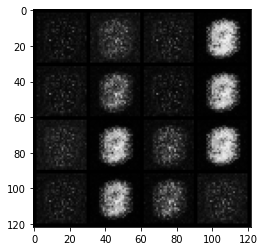

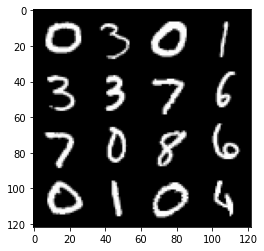

Step 2000: Generator loss: 2.3712734299898166, discriminator loss: 0.11998562395572655


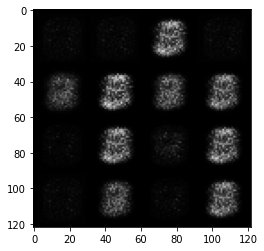

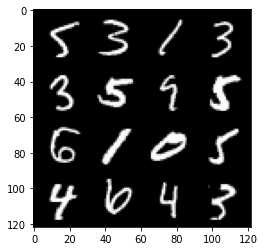

Step 3000: Generator loss: 2.188727012753488, discriminator loss: 0.10361147619411333


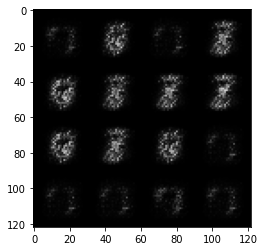

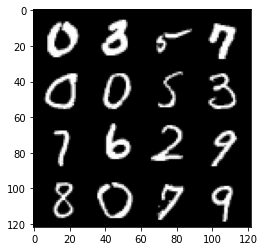

Step 4000: Generator loss: 3.2322908647060404, discriminator loss: 0.04528326029703029


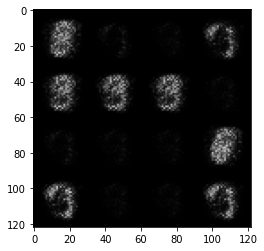

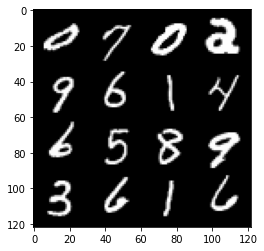

Step 5000: Generator loss: 3.741773597002031, discriminator loss: 0.03512951837293802


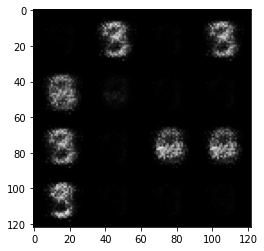

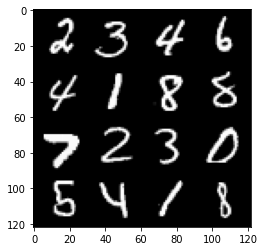

Step 6000: Generator loss: 4.098519303560258, discriminator loss: 0.039105922776274414


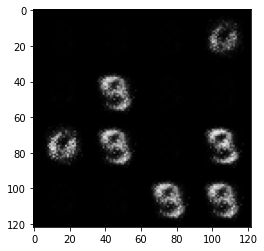

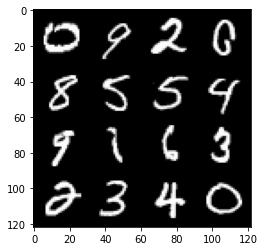

Step 7000: Generator loss: 4.476636398792263, discriminator loss: 0.030869712684303538


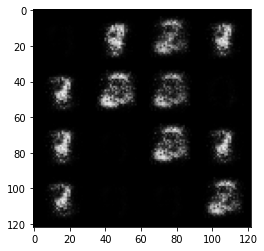

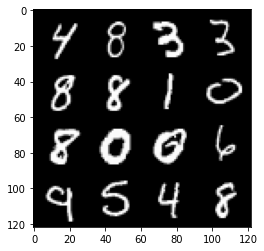

Step 8000: Generator loss: 4.583127265930176, discriminator loss: 0.040163022271357485


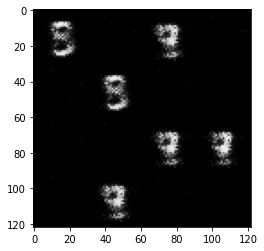

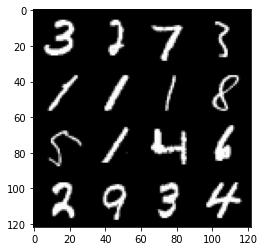

Step 9000: Generator loss: 4.796000300407413, discriminator loss: 0.03312415518518538


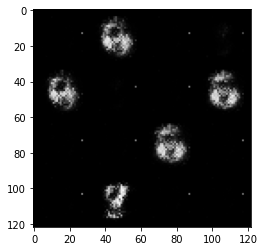

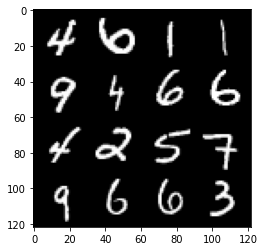

Step 10000: Generator loss: 4.993335970401766, discriminator loss: 0.03443006626795987


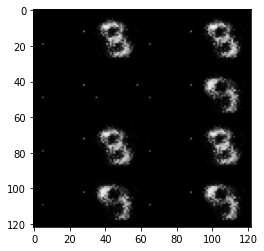

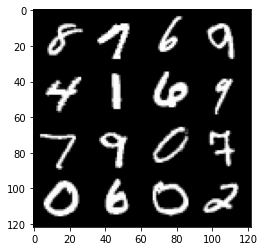

Step 11000: Generator loss: 5.3123284935951265, discriminator loss: 0.03205338604981081


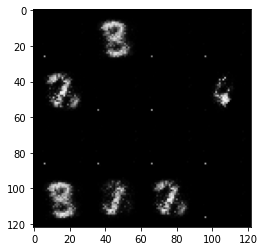

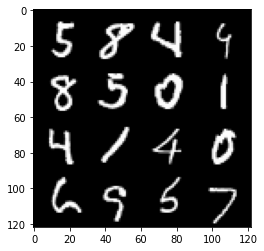

Step 12000: Generator loss: 5.328996542453768, discriminator loss: 0.04044676652457565


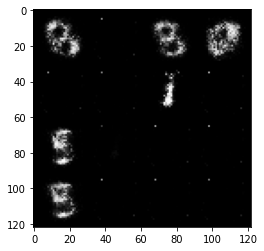

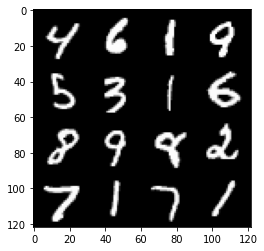

Step 13000: Generator loss: 5.749325014114377, discriminator loss: 0.03269502269104118


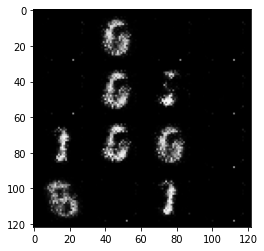

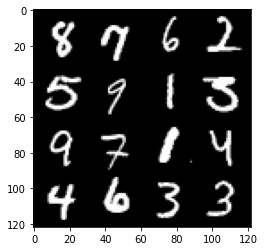

Step 14000: Generator loss: 5.898829385757452, discriminator loss: 0.03090051831258459


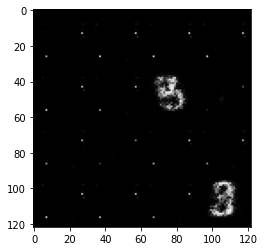

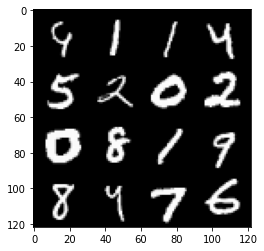

Step 15000: Generator loss: 5.968623999595641, discriminator loss: 0.03637656687572601


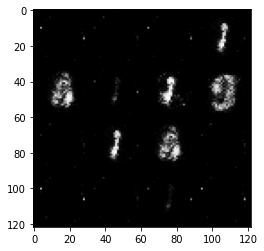

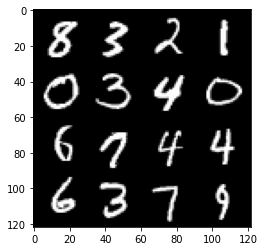

Step 16000: Generator loss: 6.235549081325536, discriminator loss: 0.04972004968393594


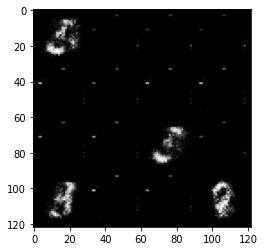

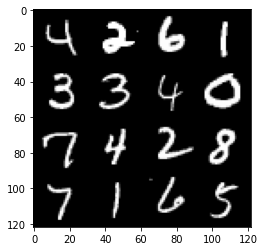

Step 17000: Generator loss: 6.317086598873145, discriminator loss: 0.06064146281871938


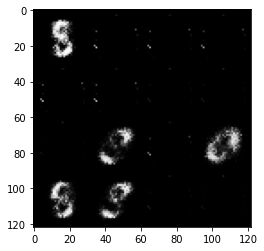

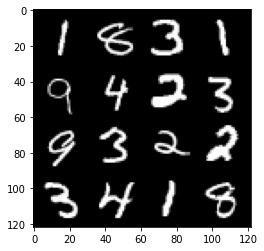

Step 18000: Generator loss: 6.320125573635107, discriminator loss: 0.05033562000375245


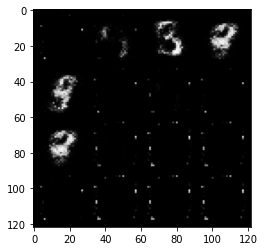

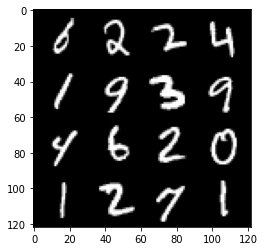

Step 19000: Generator loss: 6.414167611122121, discriminator loss: 0.06099639777652916


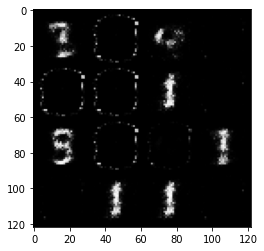

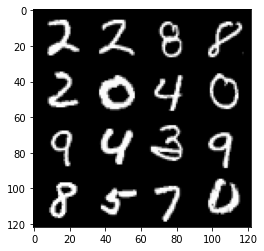

Step 20000: Generator loss: 6.448271027565, discriminator loss: 0.058006761395372496


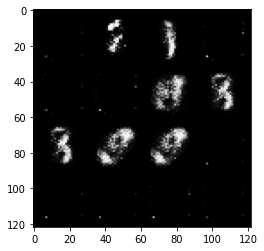

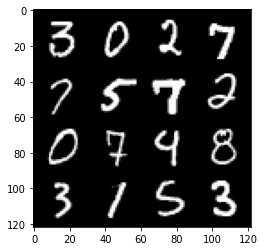

Step 21000: Generator loss: 6.013139868736271, discriminator loss: 0.06506220468133693


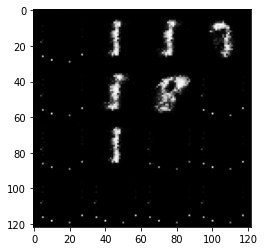

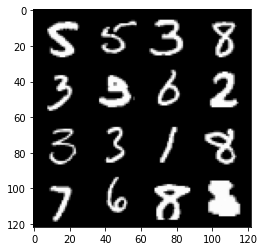

Step 22000: Generator loss: 5.791983863830564, discriminator loss: 0.06706349659524863


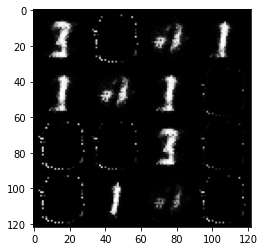

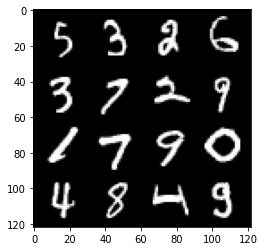

Step 23000: Generator loss: 6.016692123889924, discriminator loss: 0.06822035275027154


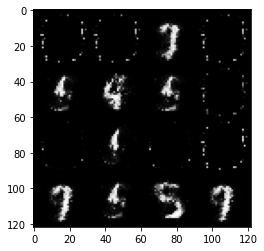

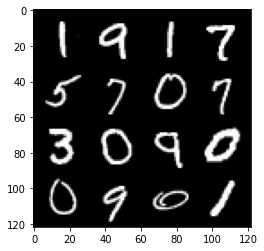

Step 24000: Generator loss: 5.969941056728358, discriminator loss: 0.07474475411139427


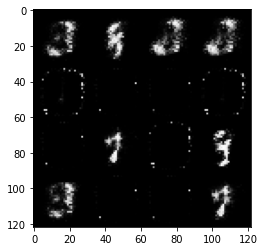

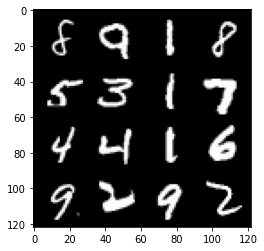

Step 25000: Generator loss: 5.930428060054774, discriminator loss: 0.08095745774917298


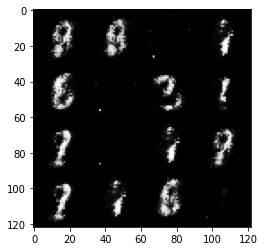

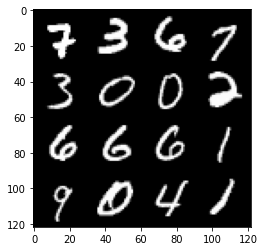

Step 26000: Generator loss: 5.347413682937621, discriminator loss: 0.10139667614549394


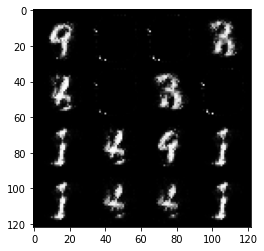

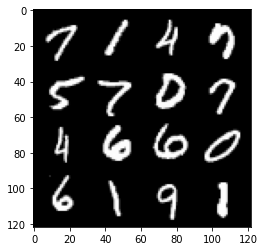

Step 27000: Generator loss: 4.886584841251375, discriminator loss: 0.12087837492674573


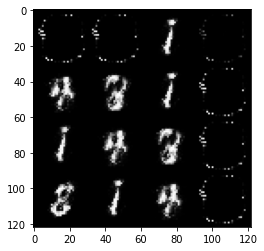

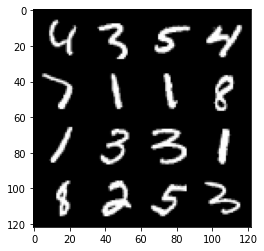

Step 28000: Generator loss: 4.964886520385749, discriminator loss: 0.12942447211593386


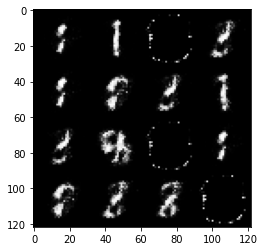

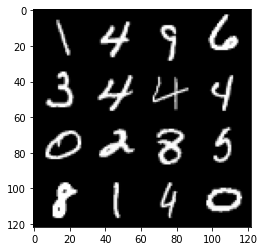

Step 29000: Generator loss: 4.88709497523308, discriminator loss: 0.1346144672147931


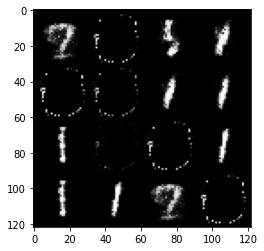

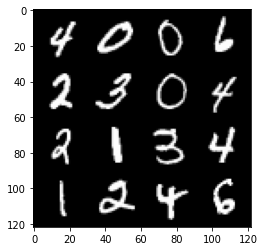

Step 30000: Generator loss: 4.790018779277804, discriminator loss: 0.147069276250899


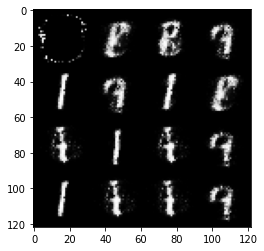

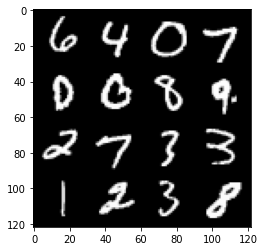

Step 31000: Generator loss: 4.68098185801506, discriminator loss: 0.1464860851019621


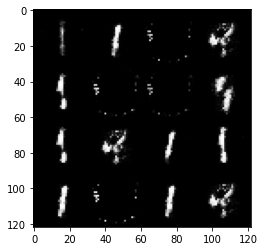

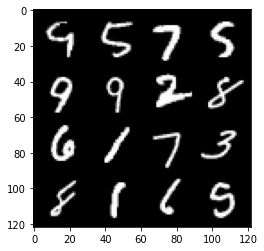

Step 32000: Generator loss: 4.561051164388659, discriminator loss: 0.1483556667417287


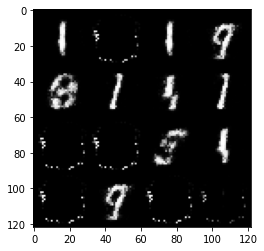

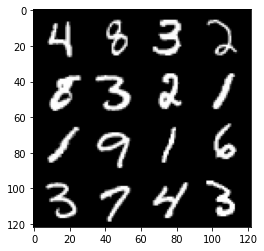

Step 33000: Generator loss: 4.240904662132265, discriminator loss: 0.15934102904051536


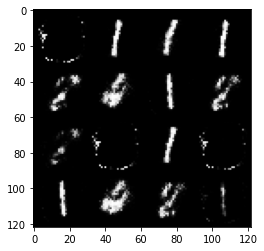

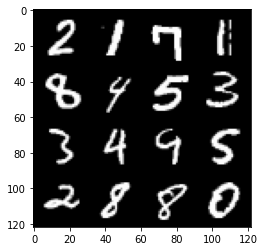

Step 34000: Generator loss: 4.4410373404026, discriminator loss: 0.16725220594555154


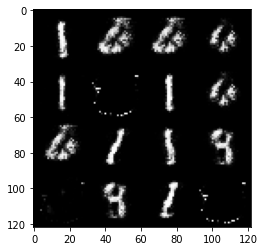

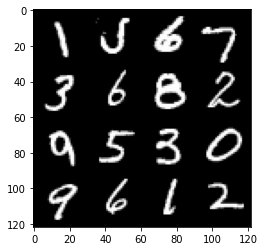

Step 35000: Generator loss: 4.199895886898039, discriminator loss: 0.15450141529738878


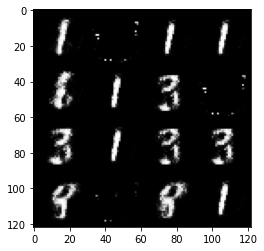

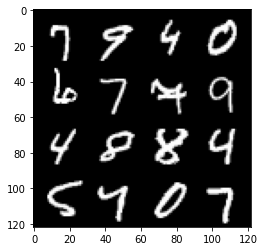

Step 36000: Generator loss: 4.085215934514996, discriminator loss: 0.16547358166053877


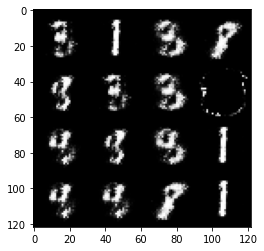

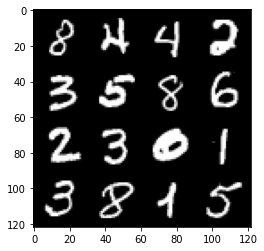

Step 37000: Generator loss: 3.856923114538193, discriminator loss: 0.1604609811604023


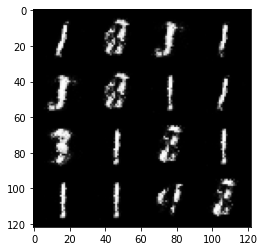

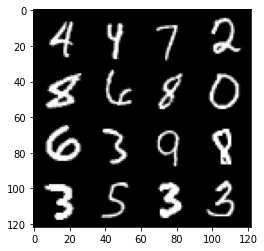

Step 38000: Generator loss: 3.8619552602767966, discriminator loss: 0.1613256946280602


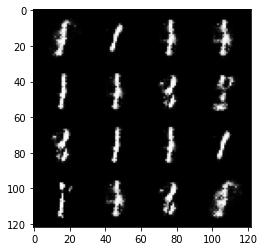

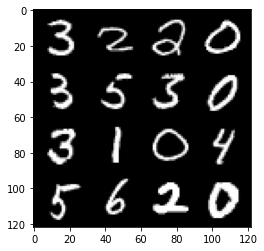

Step 39000: Generator loss: 3.756473579645157, discriminator loss: 0.16130908070132136


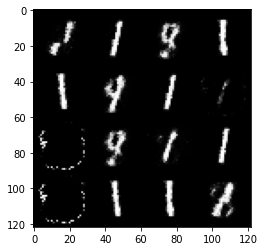

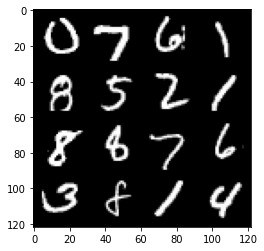

Step 40000: Generator loss: 3.334069915771481, discriminator loss: 0.18315654650330523


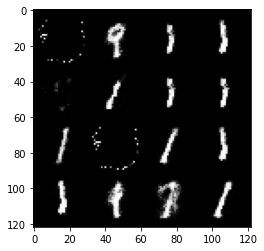

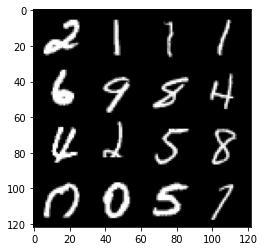

Step 41000: Generator loss: 3.3222209322452496, discriminator loss: 0.1781282491162416


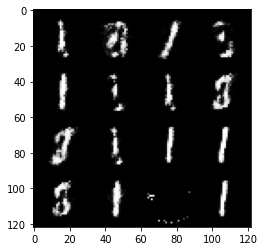

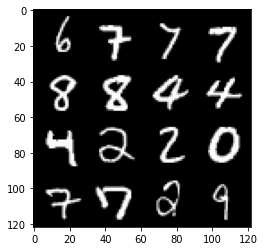

Step 42000: Generator loss: 3.233828218221665, discriminator loss: 0.19964850111305718


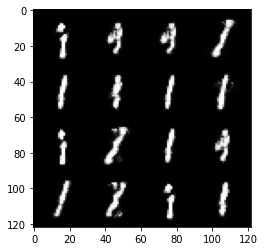

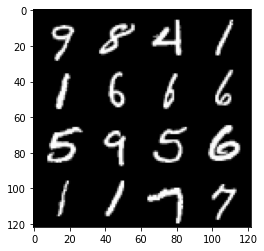

Step 43000: Generator loss: 3.090858760118488, discriminator loss: 0.20212692766636614


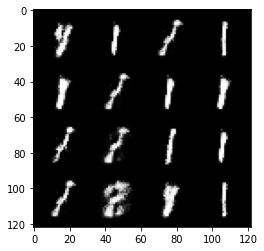

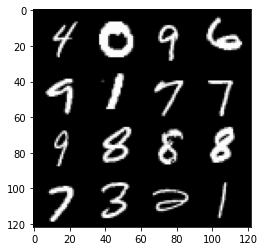

Step 44000: Generator loss: 2.9704065215587616, discriminator loss: 0.21929814606159925


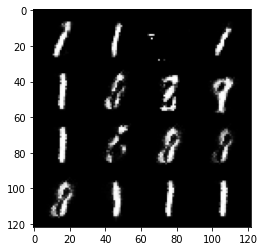

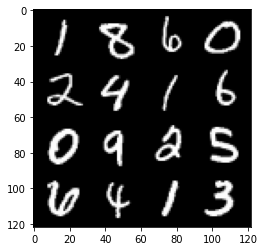

Step 45000: Generator loss: 2.9782018694877643, discriminator loss: 0.20672566210478527


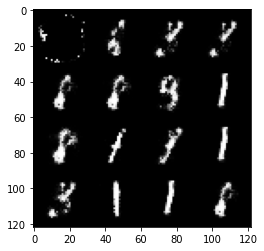

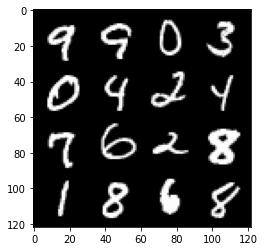

Step 46000: Generator loss: 2.8775881052017245, discriminator loss: 0.22804505392163996


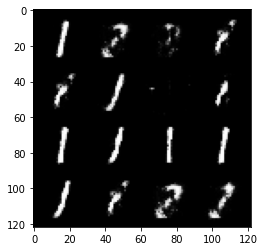

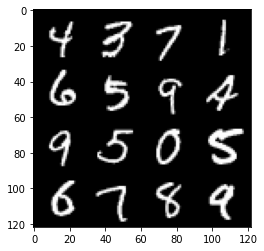

Step 47000: Generator loss: 2.564274818778039, discriminator loss: 0.2169208755642176


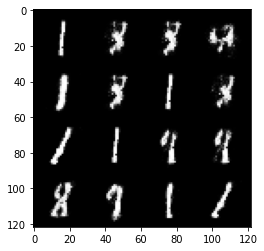

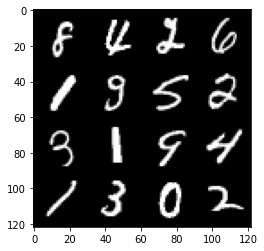

Step 48000: Generator loss: 2.5471868319511395, discriminator loss: 0.2316891097202898


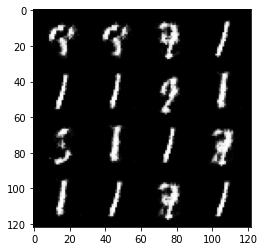

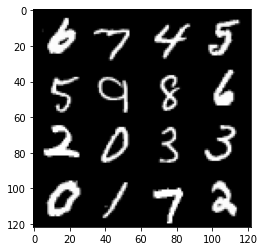

Step 49000: Generator loss: 2.4120431272983596, discriminator loss: 0.2570074831917882


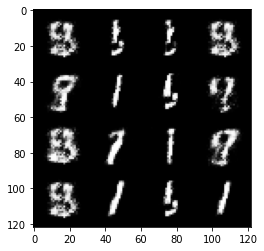

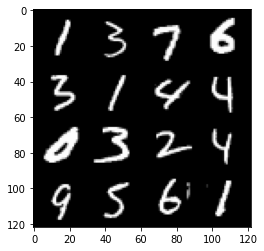

Step 50000: Generator loss: 2.3837135263681355, discriminator loss: 0.2547937073111533


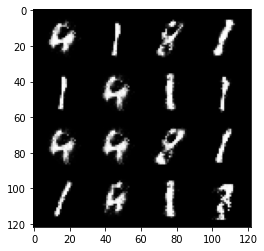

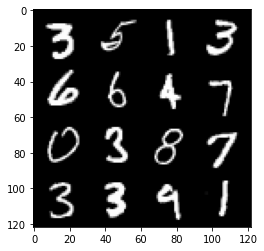

Step 51000: Generator loss: 2.36036761724949, discriminator loss: 0.2634425945878026


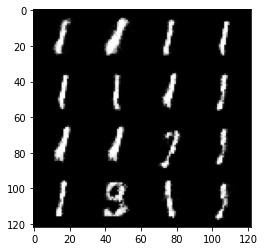

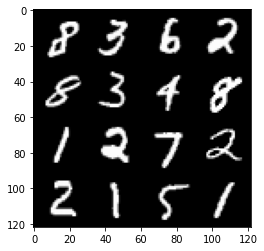

Step 52000: Generator loss: 2.4477465931177154, discriminator loss: 0.23557567661255585


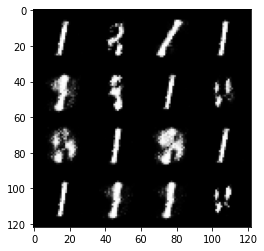

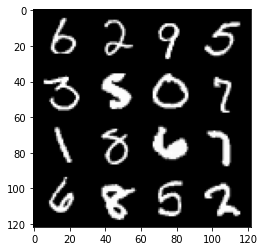

Step 53000: Generator loss: 2.361092548251152, discriminator loss: 0.24838398081809282


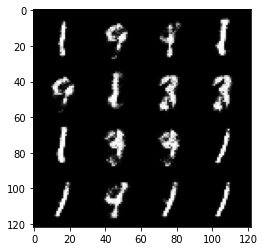

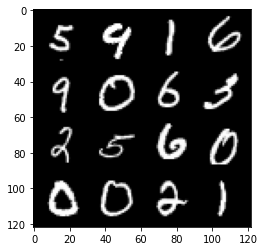

Step 54000: Generator loss: 2.371375430464742, discriminator loss: 0.24543535042554118


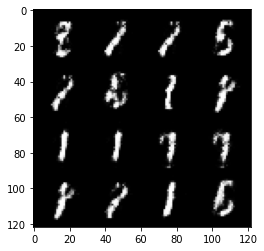

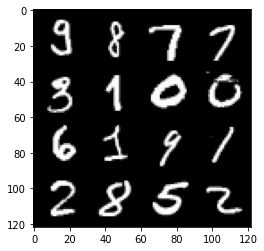

Step 55000: Generator loss: 2.3493174341917054, discriminator loss: 0.23632966113090523


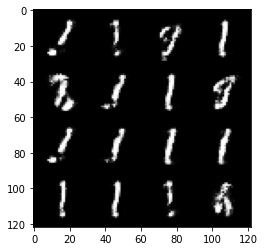

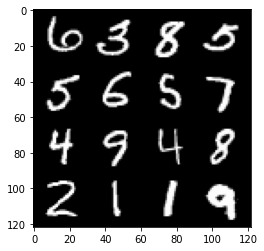

Step 56000: Generator loss: 2.354076360344883, discriminator loss: 0.24355911182612158


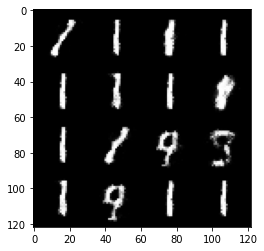

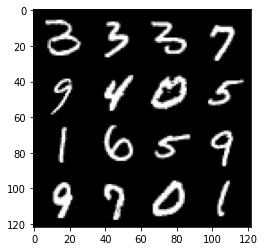

Step 57000: Generator loss: 2.3998350014686634, discriminator loss: 0.24187819269299518


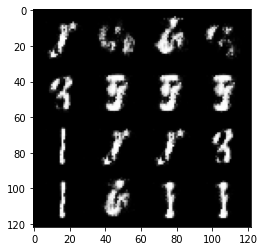

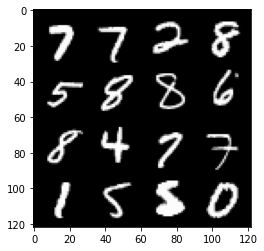

Step 58000: Generator loss: 2.2182746542692167, discriminator loss: 0.25807880252599746


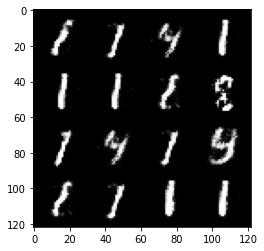

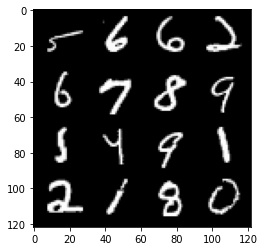

Step 59000: Generator loss: 2.204273105740547, discriminator loss: 0.2805116318464276


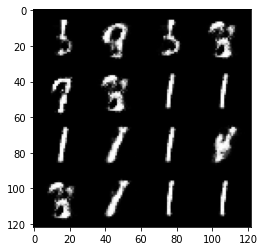

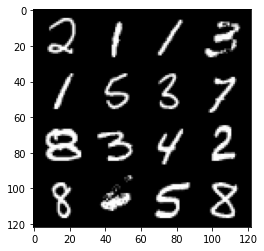

Step 60000: Generator loss: 2.079370739102365, discriminator loss: 0.3002145284116268


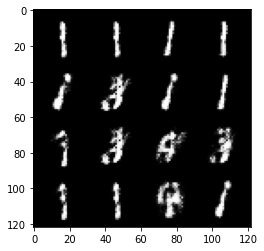

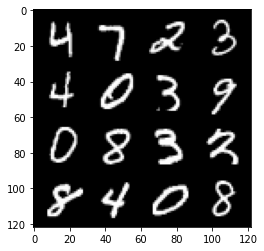

Step 61000: Generator loss: 2.1356782058477393, discriminator loss: 0.2924670455604789


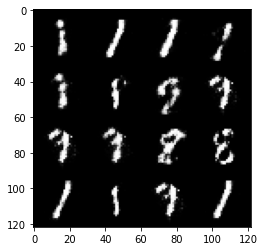

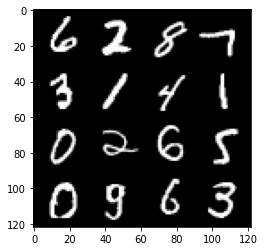

Step 62000: Generator loss: 2.005261746644971, discriminator loss: 0.3186658859103919


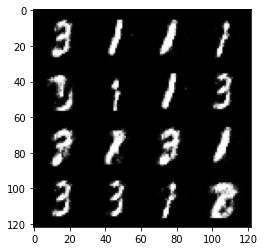

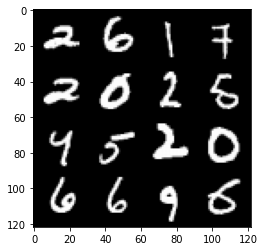

Step 63000: Generator loss: 2.046567140936851, discriminator loss: 0.2877541223913433


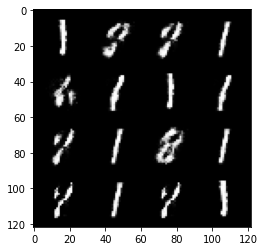

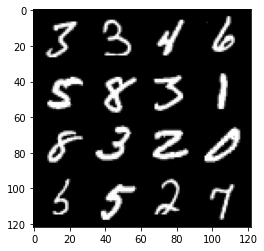

Step 64000: Generator loss: 2.1022422740459428, discriminator loss: 0.2889255111217499


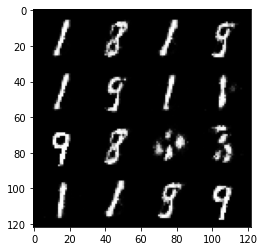

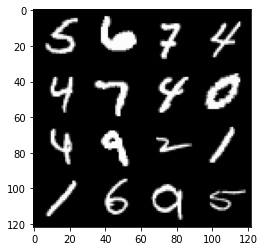

Step 65000: Generator loss: 2.115461828947067, discriminator loss: 0.29002209329605116


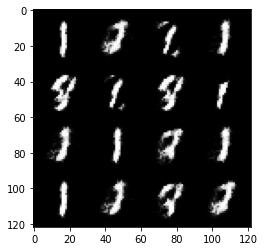

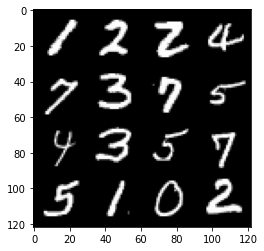

Step 66000: Generator loss: 2.159212521195415, discriminator loss: 0.2717631916254759


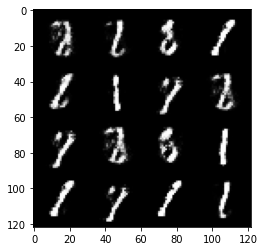

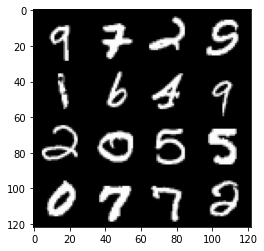

Step 67000: Generator loss: 2.1388402104377757, discriminator loss: 0.2741693704873322


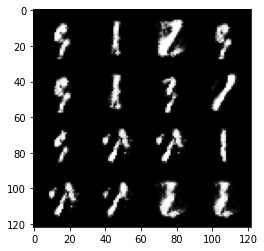

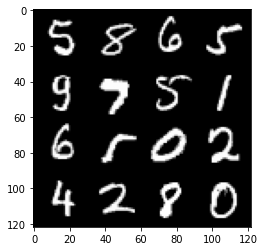

Step 68000: Generator loss: 2.226582775831225, discriminator loss: 0.25043894897401353


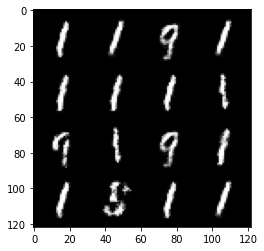

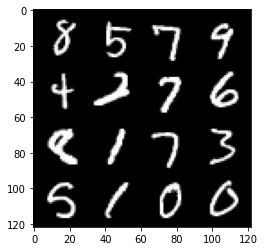

Step 69000: Generator loss: 2.2957068406343453, discriminator loss: 0.24978200705349432


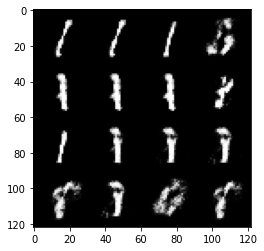

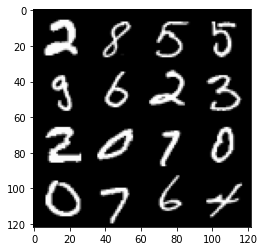

Step 70000: Generator loss: 2.207768718004224, discriminator loss: 0.26827718172967435


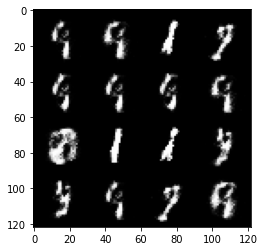

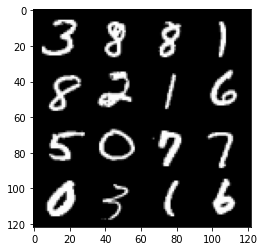

Step 71000: Generator loss: 2.0339920045137387, discriminator loss: 0.2962668222934006


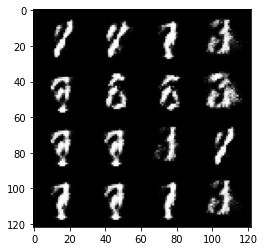

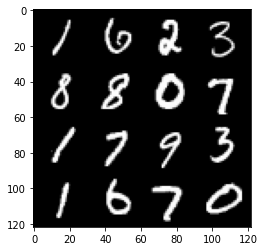

Step 72000: Generator loss: 1.954271641612053, discriminator loss: 0.30880941347777874


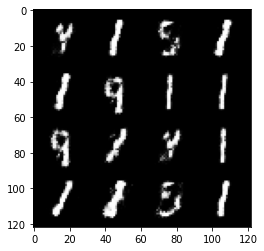

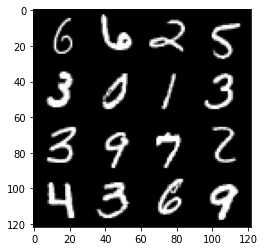

Step 73000: Generator loss: 1.7650999283790572, discriminator loss: 0.370720412835479


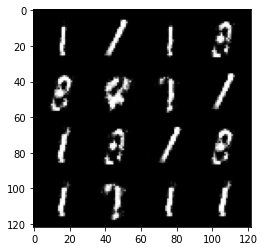

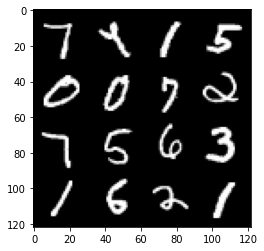

Step 74000: Generator loss: 1.8272807320356375, discriminator loss: 0.3432308144867426


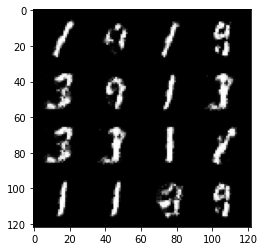

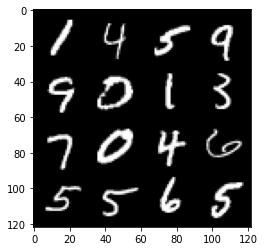

Step 75000: Generator loss: 1.8108189773559555, discriminator loss: 0.34361049653589754


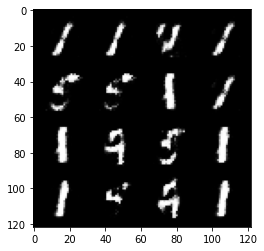

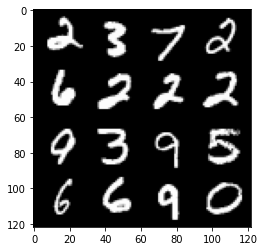

Step 76000: Generator loss: 1.829909690618516, discriminator loss: 0.34165648627281175


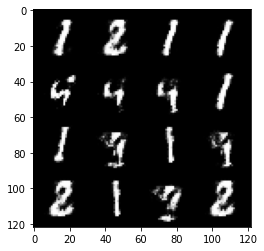

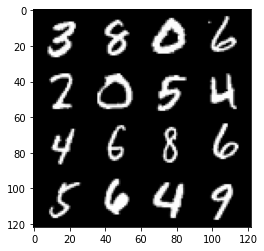

Step 77000: Generator loss: 1.7889788179397594, discriminator loss: 0.3409325148165235


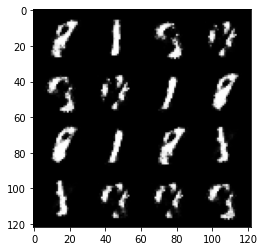

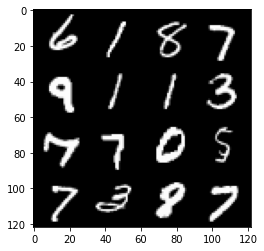

Step 78000: Generator loss: 1.874583460688593, discriminator loss: 0.31553766086697593


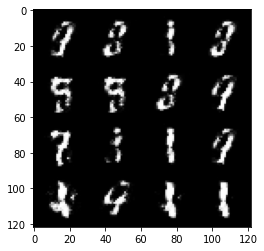

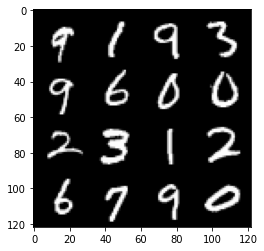

Step 79000: Generator loss: 1.9230807088613524, discriminator loss: 0.3086443466842177


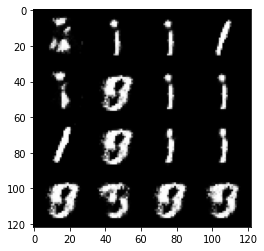

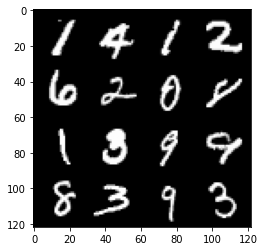

Step 80000: Generator loss: 1.9475924553871167, discriminator loss: 0.2993207916617388


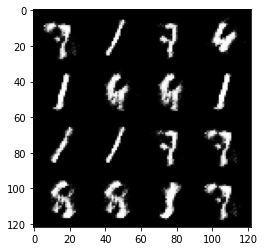

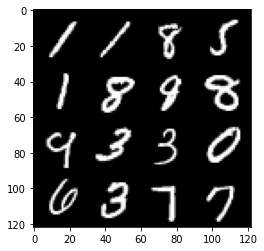

Step 81000: Generator loss: 1.9944352861642847, discriminator loss: 0.3071545140296225


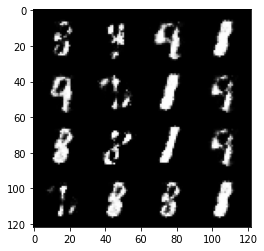

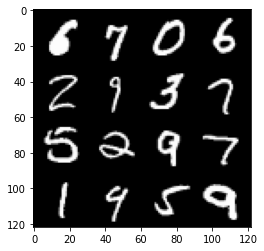

Step 82000: Generator loss: 1.7942144351005562, discriminator loss: 0.3524991824030871


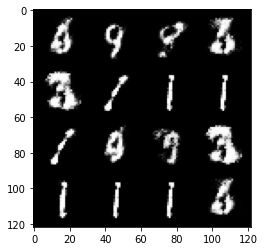

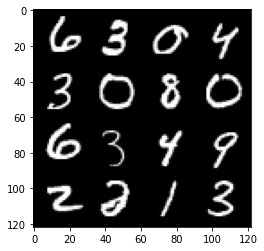

Step 83000: Generator loss: 1.8013947767019258, discriminator loss: 0.33211624081432783


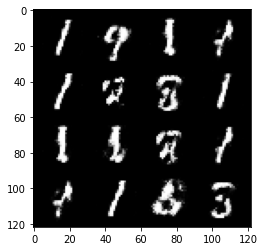

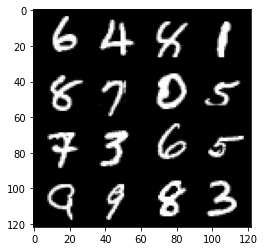

Step 84000: Generator loss: 1.648348818421364, discriminator loss: 0.38014315161108964


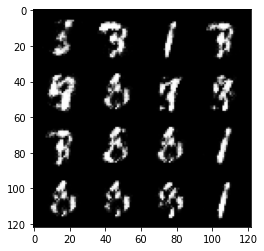

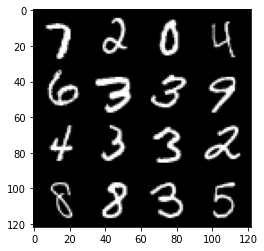

Step 85000: Generator loss: 1.7125084947347635, discriminator loss: 0.35891332730650893


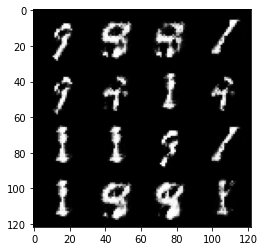

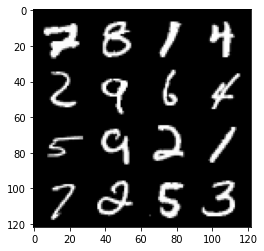

Step 86000: Generator loss: 1.7027354736328126, discriminator loss: 0.35366938620805705


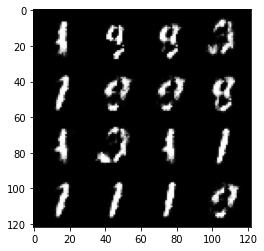

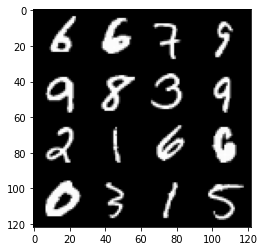

Step 87000: Generator loss: 1.6552404870986959, discriminator loss: 0.3687134445160626


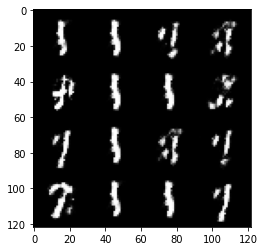

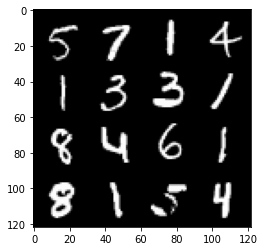

Step 88000: Generator loss: 1.7411419626474371, discriminator loss: 0.34474143989384165


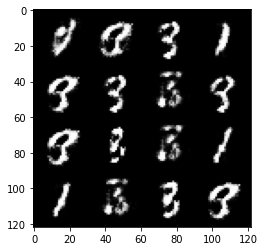

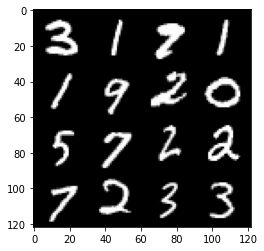

Step 89000: Generator loss: 1.6288276631832117, discriminator loss: 0.38018536938726943


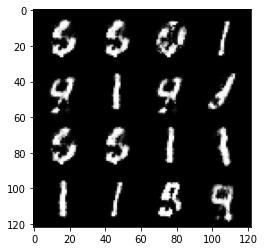

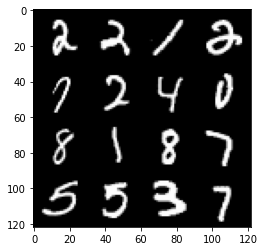

Step 90000: Generator loss: 1.6324252122640608, discriminator loss: 0.37422621822357127


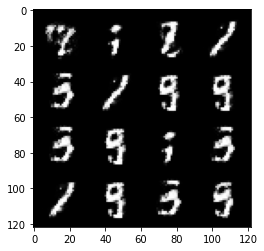

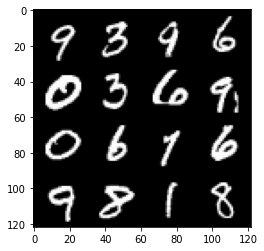

Step 91000: Generator loss: 1.6797925066947965, discriminator loss: 0.35795237031579025


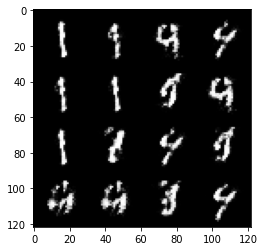

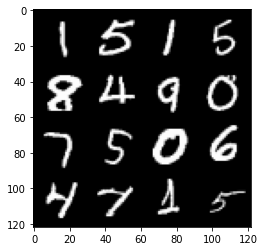

Step 92000: Generator loss: 1.5822162389755263, discriminator loss: 0.381499924957752


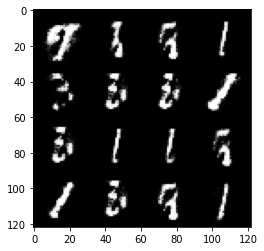

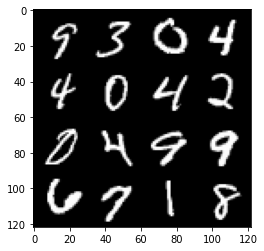

Step 93000: Generator loss: 1.5091037830114373, discriminator loss: 0.4023818800449373


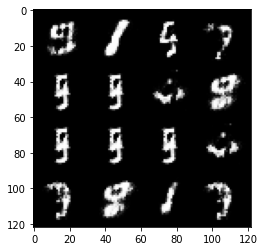

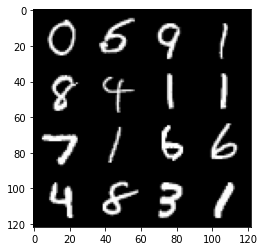

In [8]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0


for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, label in tqdm(dataloader):
        cur_batch_size = len(real)
        
        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = gen.get_noise(cur_batch_size, device=device)
        fake = gen(fake_noise)

        # # for fake images
        # detaching generator because we have to update only discriminator weights
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        # for real images
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        # mean discriminator loss
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = gen.get_noise(cur_batch_size, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1